In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
import numpy as np
from PIL import Image
import random
import math
from itertools import product
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit, cross_val_score
from scipy.signal import medfilt2d
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from tqdm import tqdm
import matplotlib.colors as colors
import numba

%matplotlib inline

In [2]:
def plot_image(image_arr, **kwargs):
    cmap = matplotlib.cm.gray
    cmap.set_bad('red')
    plt.imshow(image_arr, interpolation='nearest', cmap=cmap, vmin=0, vmax=255)
    plt.colorbar()
    plt.title(kwargs.get('title', None))
    plt.show() 
    
def plot_basis_matrix_chip(basis_matrix):
    plt.imshow(basis_vector_matrix, cmap='gray')
    plt.colorbar()
    plt.show()
    
def plot_alpha_map(alpha_map_arr, **kwargs):
    plt.imshow(alpha_map_arr, cmap='gray', norm=colors.LogNorm(vmin=1e-6, vmax=1e6))
    plt.colorbar()
    plt.title(kwargs.get('title', None))
    plt.show()

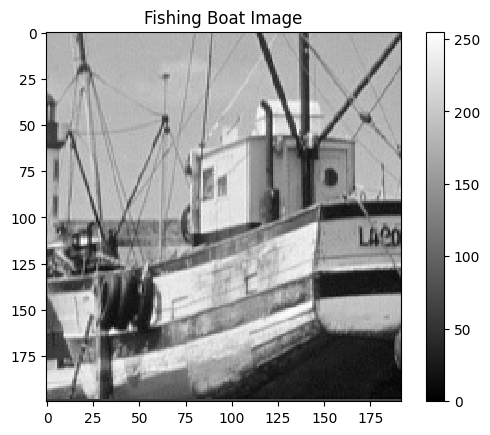

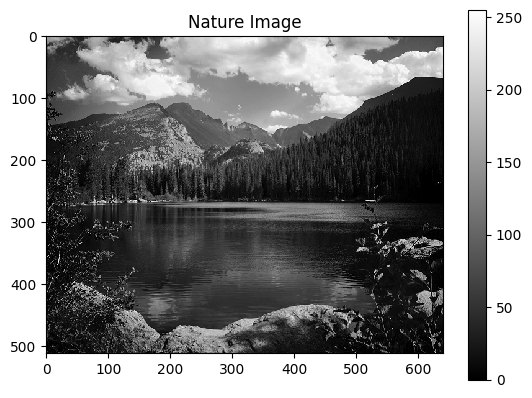

In [3]:
nature = Image.open('nature.png')
fishing_boat = Image.open('fishing_boat.png')
plot_image(np.array(fishing_boat), title='Fishing Boat Image')
plot_image(np.array(nature), title='Nature Image')

In [4]:
print(np.array(fishing_boat).shape)
print(np.array(nature).shape)

(200, 192)
(512, 640)


In [4]:
def block_shaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array looks like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return np.array(arr.reshape(h // nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def unblock_shaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return np.array(arr.reshape(h // nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

# corrupt a single k * k block, retaining S pixels
def corrupt_block(block, S):
    k = len(block)
    assert 0 <= S <= k * k, f'''number of retained blocks must be between 0 and {k * k}, inclusive'''
    pool = [*product(range(k), range(k))]
    random_indices = random.sample(pool, k * k - S)
    for r, c in random_indices:
        block[r][c] = 'NaN'
    return block
    
# corrupt an entire image by splitting into k * k blocks, retaining S pixels per block
# image does not have to be in numpy arr format
def synthesize_corrupt_image(image, k, S):
    assert 0 <= S <= k * k, f'''number of retained blocks must be between 0 and {k * k}, inclusive'''
    pixels = np.array(image)
    rows, cols = len(pixels), len(pixels[0])
    blocks = np.array(block_shaped(pixels, k, k)).astype('float')
    for block in blocks:
        corrupt_block(block, S)
    return unblock_shaped(blocks, rows, cols)

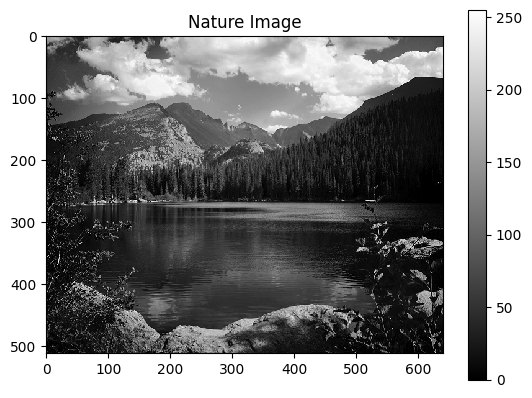

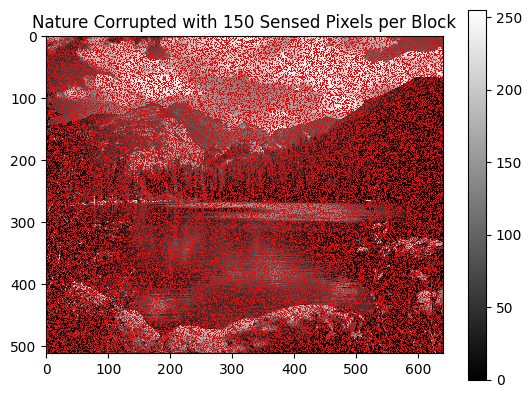

In [5]:
plot_image(nature, title='Nature Image')
# corrupted = synthesize_corrupt_image(nature, 16, 150)
S = 150
corrupted = synthesize_corrupt_image(nature, 16, S)
plot_image(corrupted, title=f'''Nature Corrupted with {S} Sensed Pixels per Block''')

In [6]:
# P is # rows, Q is # cols, 
def generate_basis_vector_matrix(P, Q):
    column_vectors = []
    for v in range(1, Q + 1):
        for u in range(1, P + 1):
            column_vectors.append(generate_chip_vector(u, v, P, Q).reshape(P*Q))
    return np.stack(column_vectors, axis=-1)

@numba.jit(nopython=True)
def generate_chip_vector(u, v, P, Q):
    chip_vector = []
    for x in range(1, P + 1):
        for y in range(1, Q + 1):
            alpha_u = math.sqrt(1 / P) if u == 1 else math.sqrt(2 / Q)
            beta_v = math.sqrt(1 / P) if v == 1 else math.sqrt(2 / Q)
            chip_vector.append(alpha_u * beta_v *
                                math.cos((math.pi * (2 * x - 1) * (u - 1)) / (2 * P)) *
                                math.cos((math.pi * (2 * y - 1) * (v - 1)) / (2 * Q)))
    return np.array(chip_vector)

# reconstruct an entire image by splitting into k * k blocks, reconstructing each block then concatenating
# corrupted image should be a numpy arr of type 'float'
def reconstruct_image(corrupted_image, k):
    basis_vector_matrix = generate_basis_vector_matrix(P=k, Q=k)
    rows, cols = len(corrupted_image), len(corrupted_image[0])
    blocks = np.array(block_shaped(corrupted_image, k, k))
    alphas = []
    S = np.count_nonzero(~np.isnan(blocks[0]))
    for i in tqdm(range(len(blocks))):
        reconstructed, alpha_best = reconstruct_block(blocks[i], basis_vector_matrix, S, show_MSE_vs_alpha=False)
        blocks[i] = reconstructed
        alphas.append(alpha_best)
    return unblock_shaped(blocks, rows, cols), np.reshape(alphas, (rows // k, cols // k))
    
# B is basis vector matrix
@ignore_warnings(category=ConvergenceWarning)
@ignore_warnings(category=UndefinedMetricWarning)
def reconstruct_block(corrupted_block, B, S, show_MSE_vs_alpha):
    k = len(corrupted_block)
    C = corrupted_block.reshape((k * k))
    corrupt_indices = np.argwhere(np.isnan(C)).reshape((k * k - S))
    D = corrupted_block[np.logical_not(np.isnan(corrupted_block))].reshape((S)) # targets D is (S=150, 1)
    A = np.delete(B, corrupt_indices, axis=0)[:,1:] # features A is (S=150, P=256) -> (150, 255) after removing constant col
    alpha_best = get_cross_val_alpha(A, D, show_MSE_vs_alpha)
    clf = Lasso(alpha=alpha_best, max_iter=10_000, warm_start=True)
    clf.fit(A, D)
    C_pred = np.dot(B[:,1:], clf.coef_) + np.mean(D) # generate reconstructed vector w/ mean sensed pixel intensity
    for i in range(len(C_pred)):
        if i not in corrupt_indices:
            C_pred[i] = C[i]
    return C_pred.reshape((k, k)), alpha_best

# X is the sensed rows of the basis vector matrix (A), y is the array of sensed pixels (D)
@ignore_warnings(category=ConvergenceWarning)
@ignore_warnings(category=UndefinedMetricWarning)
def get_cross_val_alpha(X, y, show_MSE_vs_alpha):
    cv = ShuffleSplit(n_splits=1, test_size=1/6)
    alphas = np.logspace(-6, 6, 36)
    alpha_best = 1
    min_MSE = float('inf')
    M = 20 # change this
    MSEs = []
    for alpha in alphas:
        model = Lasso(alpha=alpha, max_iter=10_000, warm_start=True)
        iteration_scores = []
        for i in range(M):
            iteration_scores.append(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1))
        mean_alpha_score = np.mean(iteration_scores)
        if mean_alpha_score < min_MSE:
            min_MSE = mean_alpha_score
            alpha_best = alpha
        MSEs.append(mean_alpha_score)
    if show_MSE_vs_alpha:
        plot_MSE_vs_alpha(alphas, MSEs, alpha_best, len(y))
    return alpha_best

def plot_MSE_vs_alpha(alphas, MSEs, alpha_best, S):
    plt.semilogx(alphas, MSEs)
    plt.axvline(alpha_best, linestyle="--", color="black", label="best alpha value")
    plt.legend()
    plt.title(f'''MSE vs. Regularization Parameter with S={S} sensed pixels''')
    plt.xlabel(r"$\alpha$")
    plt.ylabel("Mean squared error")
    plt.show()

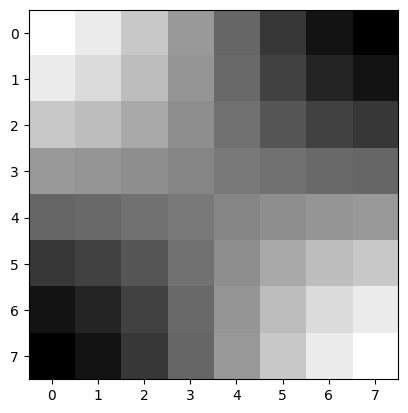

In [7]:
P, Q = 8, 8
plt.imshow(generate_chip_vector(u=2, v=2, P=P, Q=Q).reshape(P, Q), cmap='gray')
plt.show()

In [16]:
k, S = 16, 150
nature_corrupted = synthesize_corrupt_image(nature, k, S)
nature_reconstructed, nature_alpha_map = reconstruct_image(nature_corrupted, k)

100%|████████████████████████████████████████████████████████████████████████████| 1280/1280 [2:51:52<00:00,  8.06s/it]


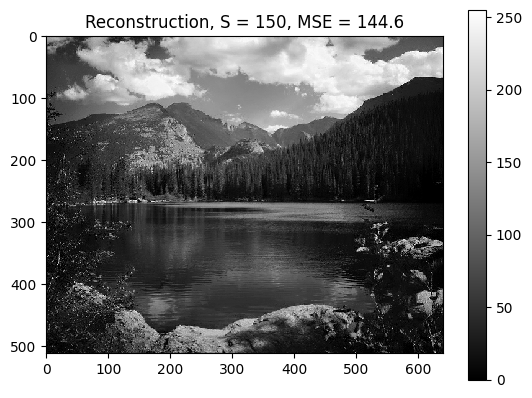

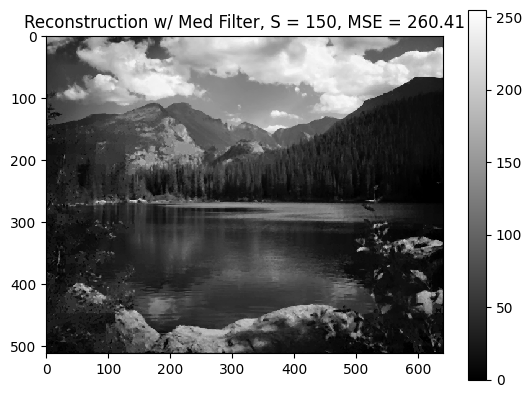

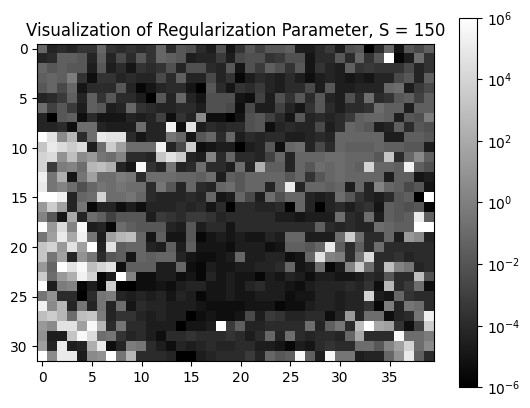

In [17]:
S = 150
reconstruction_MSE = round(mean_squared_error(np.array(nature), nature_reconstructed), 2)
nature_reconstructed_filtered = medfilt2d(nature_reconstructed)
filtered_MSE = round(mean_squared_error(np.array(nature), nature_reconstructed_filtered), 2)
plot_image(nature_reconstructed, title=f'''Reconstruction, S = {S}, MSE = {reconstruction_MSE}''')
plot_image(nature_reconstructed_filtered, title=f'''Reconstruction w/ Med Filter, S = {S}, MSE = {filtered_MSE}''')
plot_alpha_map(nature_alpha_map, title=f'''Visualization of Regularization Parameter, S = {S}''')

In [14]:
k, S = 8, 50
fishing_boat_corrupted = synthesize_corrupt_image(fishing_boat, k, S)
fishing_boat_reconstructed, fishing_boat_alpha_map = reconstruct_image(fishing_boat_corrupted, k)

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [30:44<00:00,  3.07s/it]


In [36]:
print(mean_squared_error(np.array(fishing_boat), medfilt2d(np.array(fishing_boat))))
print(mean_squared_error(np.array(nature), medfilt2d(np.array(nature))))

29.98703125
32.170562744140625


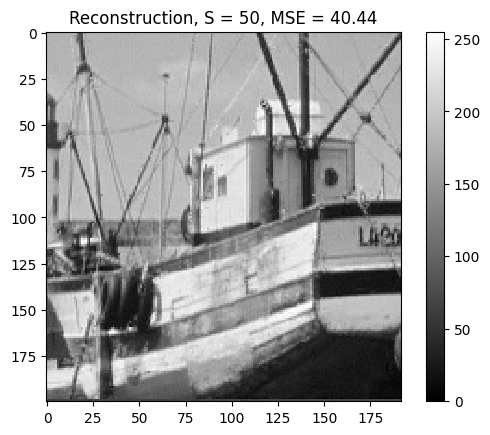

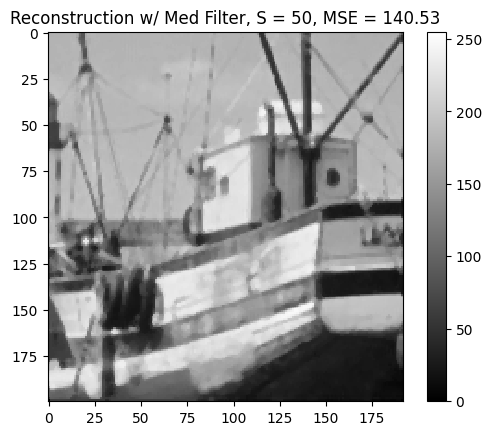

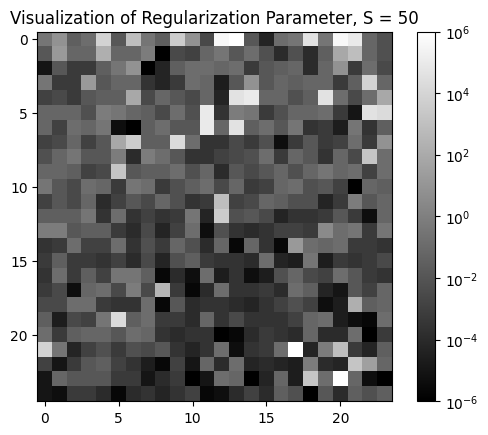

In [15]:
S = 50
reconstruction_MSE = round(mean_squared_error(np.array(fishing_boat),  fishing_boat_reconstructed), 2)
fishing_boat_reconstructed_filtered = medfilt2d(fishing_boat_reconstructed)
filtered_MSE = round(mean_squared_error(np.array(fishing_boat), fishing_boat_reconstructed_filtered), 2)
plot_image(fishing_boat_reconstructed, title=f'''Reconstruction, S = {S}, MSE = {reconstruction_MSE}''')
plot_image(fishing_boat_reconstructed_filtered, title=f'''Reconstruction w/ Med Filter, S = {S}, MSE = {filtered_MSE}''')
plot_alpha_map(fishing_boat_alpha_map, title=f'''Visualization of Regularization Parameter, S = {S}''')

In [18]:
def plot_MSE_vs_S(S_values, MSEs, MSEs_filtered, title, ratio):
    plt.scatter(S_values, MSEs)
    plt.scatter(S_values, MSEs_filtered)
    plt.plot(S_values, MSEs, linestyle='dashed', label='raw reconstruction')
    plt.plot(S_values, MSEs_filtered, linestyle='dotted', label='median-filtered')
    plt.title(title)
    plt.xlabel('Proportion of sensed pixels per block (S/K$^2$)' if ratio else '# sensed pixels per block (S)')
    plt.ylabel('mean-squared error')
    plt.legend()
    plt.show()

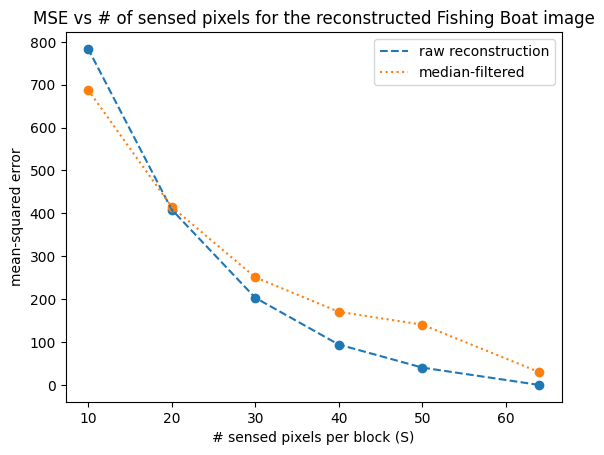

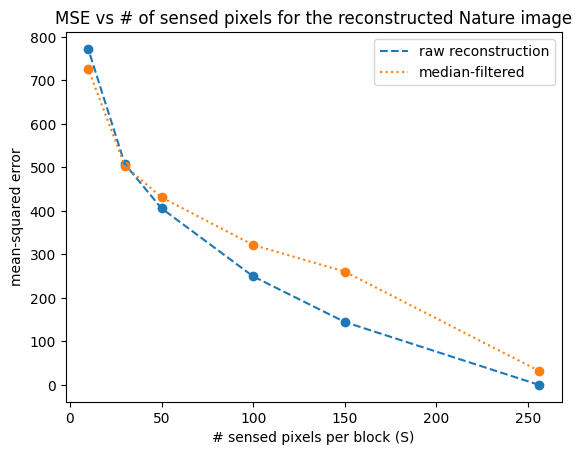

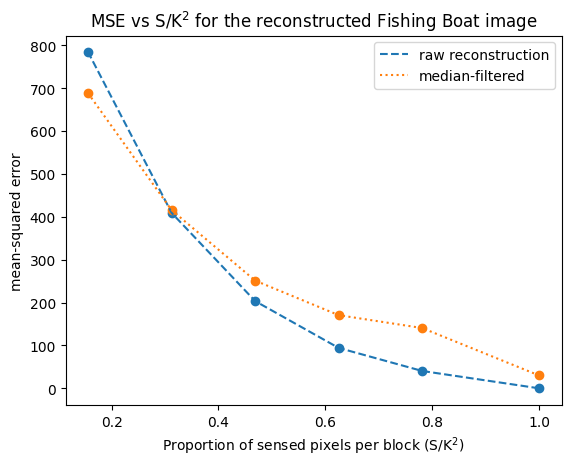

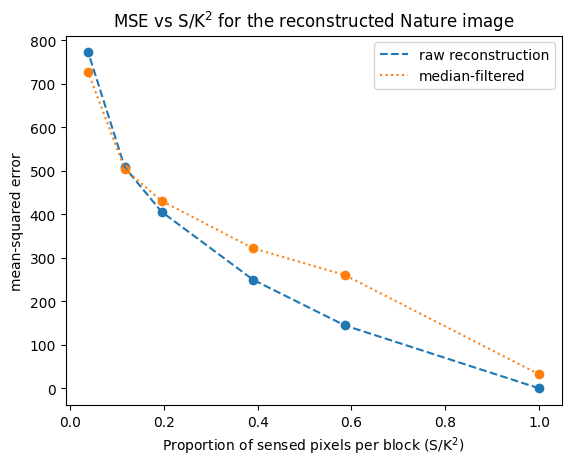

In [19]:
S_values_fishing_boat, S_values_nature = np.array([64, 50, 40, 30, 20, 10]), np.array([256, 150, 100, 50, 30, 10])
S_values_ratio_fishing_boat, S_values_ratio_nature = S_values_fishing_boat / 64, S_values_nature / 256
MSEs_fishing_boat, MSEs_nature = [0, 40.44, 94.15, 203.30, 408.87, 783.44], [0, 144.6, 249.43, 405.87, 507.57, 772.21]
MSEs_fishing_boat_filtered, MSEs_nature_filtered = [29.99, 140.53, 170.58, 251.11, 415.27, 687.69], [32.17, 260.41, 321.68, 430.91, 503.72, 726.2]

plot_MSE_vs_S(S_values=S_values_fishing_boat, MSEs=MSEs_fishing_boat, MSEs_filtered=MSEs_fishing_boat_filtered, title='MSE vs # of sensed pixels for the reconstructed Fishing Boat image''', ratio=False)
plot_MSE_vs_S(S_values=S_values_nature, MSEs=MSEs_nature, MSEs_filtered=MSEs_nature_filtered, title='MSE vs # of sensed pixels for the reconstructed Nature image''', ratio=False)
plot_MSE_vs_S(S_values=S_values_ratio_fishing_boat, MSEs=MSEs_fishing_boat, MSEs_filtered=MSEs_fishing_boat_filtered, title='MSE vs S/K$^2$ for the reconstructed Fishing Boat image''', ratio=True)
plot_MSE_vs_S(S_values=S_values_ratio_nature, MSEs=MSEs_nature, MSEs_filtered=MSEs_nature_filtered, title='MSE vs S/K$^2$ for the reconstructed Nature image''', ratio=True)

# CHECKPOINT 1

In [10]:
def plot_checkpoint_block(block, k, S):
    assert 0 <= S <= k * k, f'''number of retained blocks must be between 0 and {k * k}, inclusive'''
    cmap = matplotlib.cm.gray
    cmap.set_bad('red')
    plt.imshow(corrupt_block(block, S), cmap=cmap, vmin=0, vmax=255)
    plt.title(f'''Image of the {k}x{k} block''' + (f''' with S={S} sensed pixels''' if S < k * k else ''))
    plt.colorbar()
    plt.show()

coordinates: (49, 25)


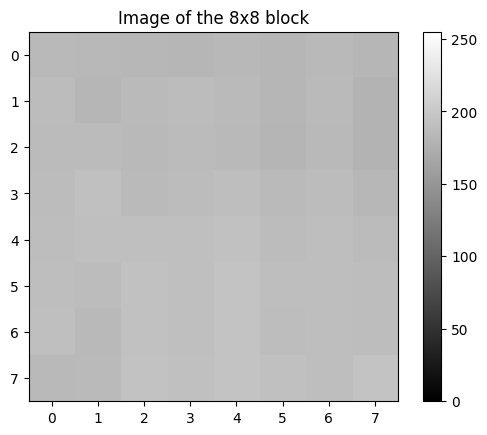

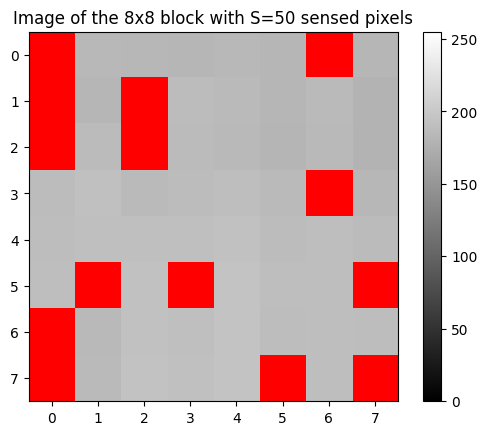

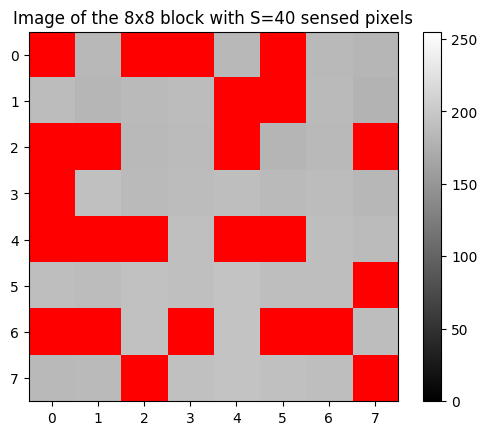

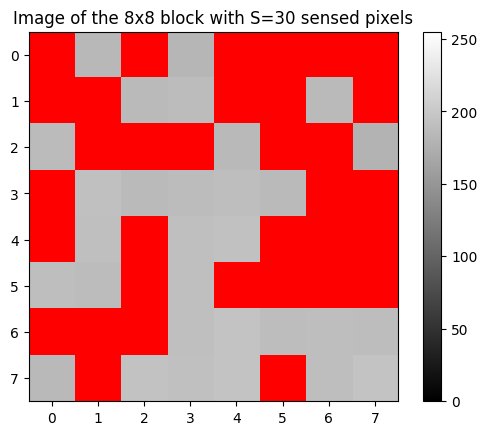

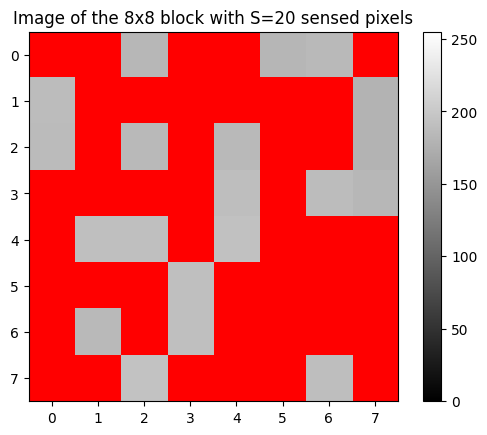

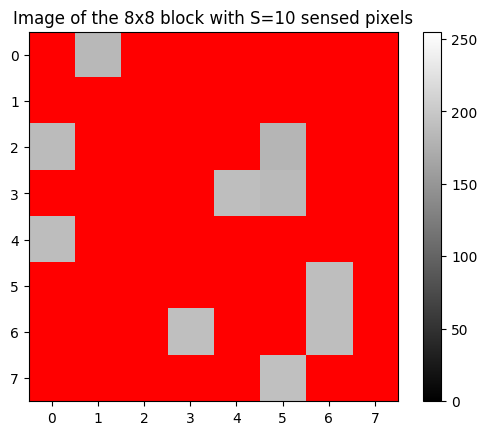

In [11]:
# fishing boat image block
first_name, last_name = "Richard", "Deng"
x, y = 8 * (len(first_name) - 1), 8 * (len(last_name) - 1)
print(f'''coordinates: ({x + 1}, {y + 1})''')
k = 8
fishing_boat_block = np.array(fishing_boat.crop((x, y, x + k, y + k))).astype('float')
S_vals = [k * k, 50, 40, 30, 20, 10]
for S in S_vals:
    plot_checkpoint_block(np.copy(fishing_boat_block), k, S)

coordinates: (273, 49)


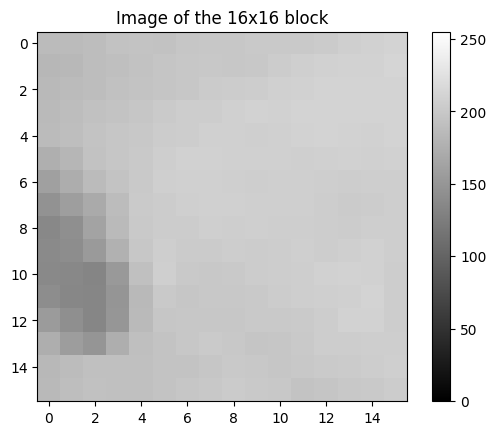

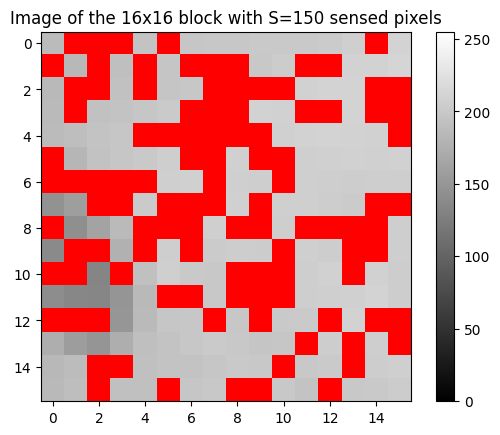

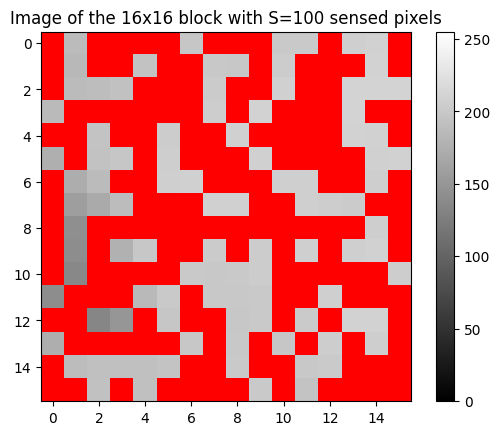

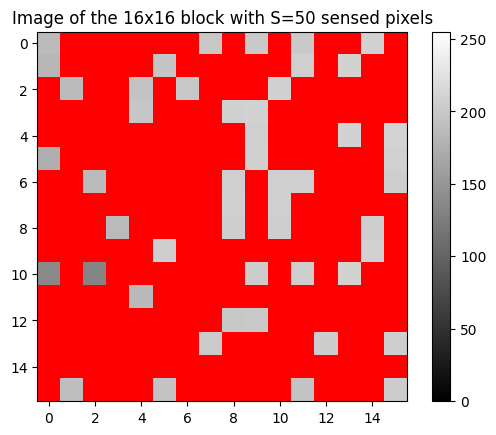

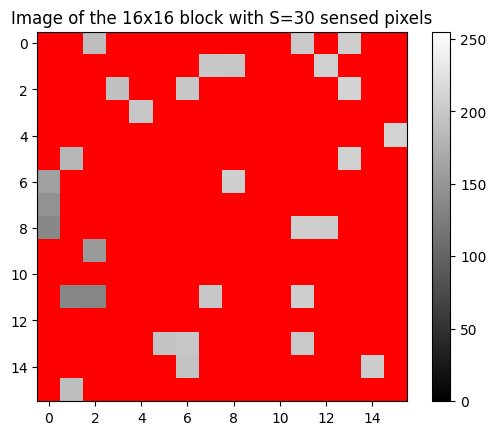

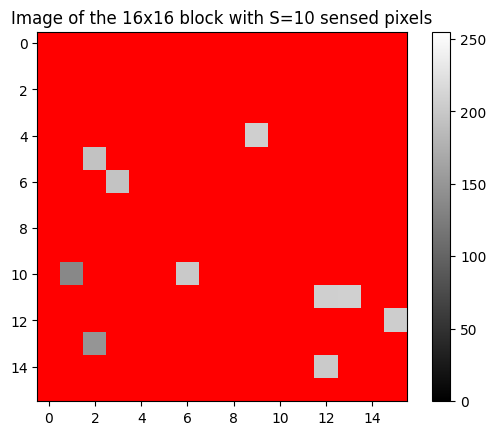

In [12]:
# nature image block
initials = 'RD'
x, y = 16 * (ord(initials[0]) - ord('A')), 16 * (ord(initials[1]) - ord('A'))
print(f'''coordinates: ({x + 1}, {y + 1})''')
k = 16
S_vals = [k * k, 150, 100, 50, 30, 10]
nature_block = np.array(nature.crop((x, y, x + k, y + k))).astype('float')
for S in S_vals:
    plot_checkpoint_block(np.copy(nature_block), k, S)

# CHECKPOINT 2

In [8]:
def generate_and_visualize_basis_matrix(k):
    basis_vector_matrix = generate_basis_vector_matrix(P=k, Q=k)
    plt.title(f'''Visualization of basis vector matrix for K={k}''')
    plt.imshow(basis_vector_matrix, cmap='gray')
    plt.colorbar()
    plt.show()
    return basis_vector_matrix

def plot_checkpoint_reconstructed_block(block, k, S):
    assert 0 <= S <= k * k, f'''number of retained blocks must be between 0 and {k * k}, inclusive'''
    plt.title(f'''Image of reconstructed the {k}x{k} block with S={S} sensed pixels''')
    block = np.array(block, subok=True)
    plt.imshow(block, interpolation='nearest', cmap=matplotlib.cm.gray, vmin=0, vmax=255)
    plt.colorbar()
    plt.show()

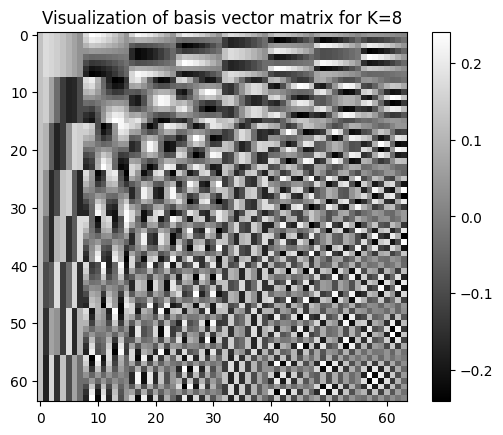

coordinates: (49, 25)


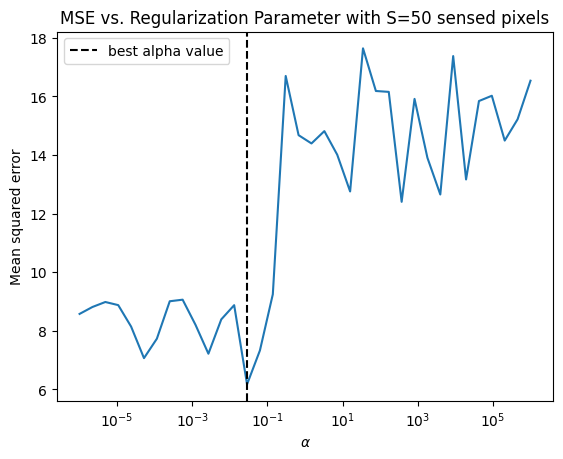

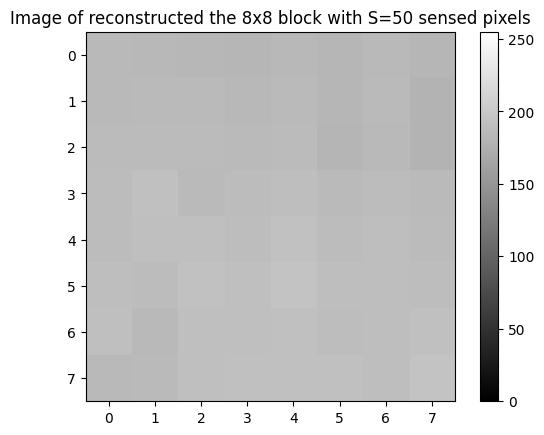

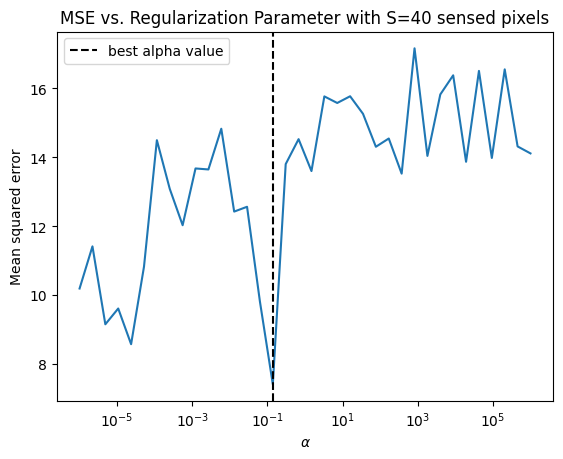

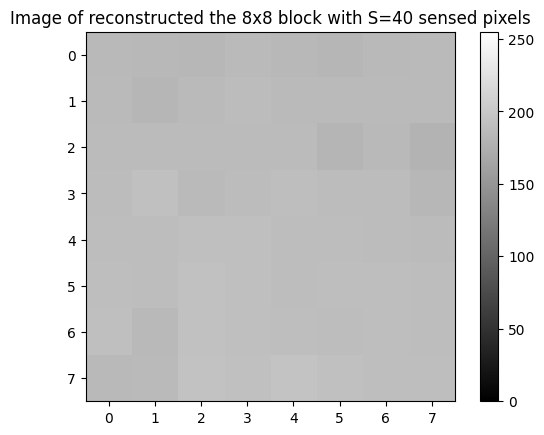

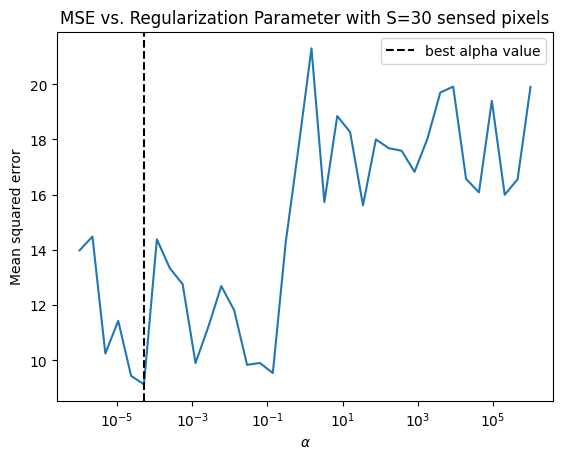

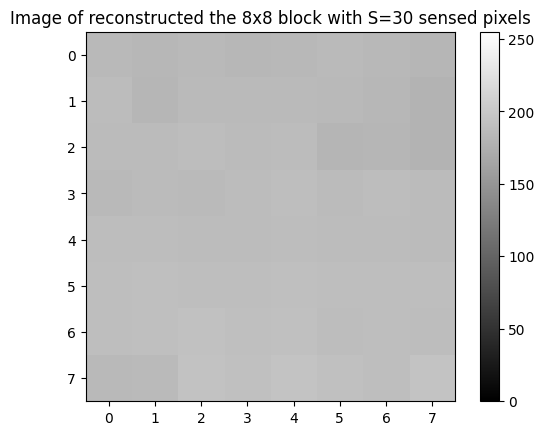

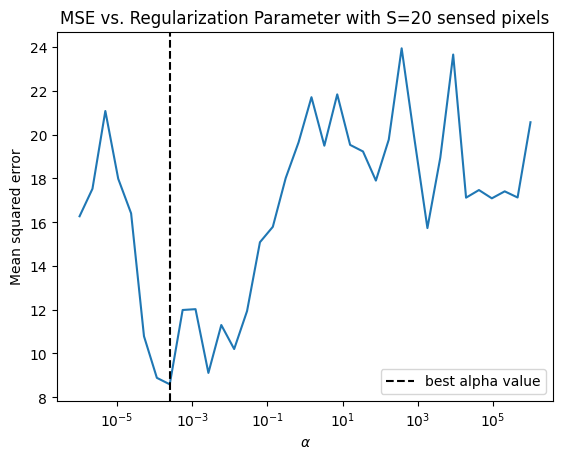

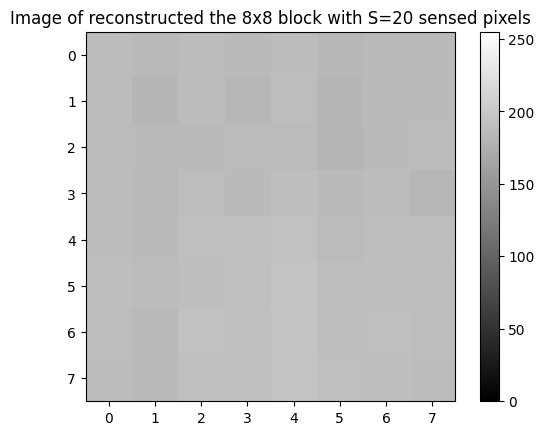

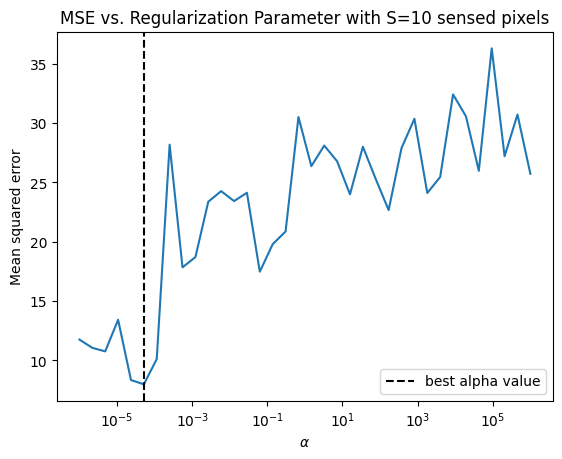

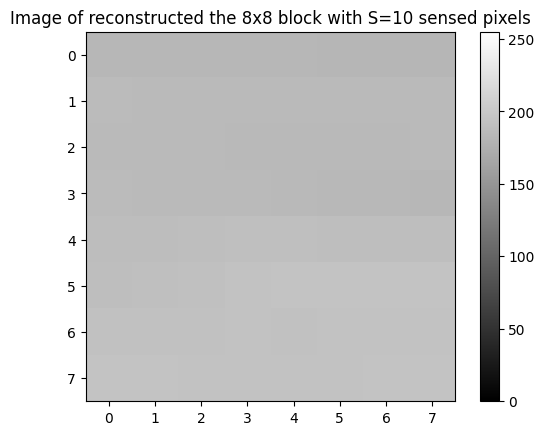

In [9]:
# fishing boat image block
k = 8
basis_vector_matrix_8 = generate_and_visualize_basis_matrix(k)
first_name, last_name = "Richard", "Deng"
x, y = 8 * (len(first_name) - 1), 8 * (len(last_name) - 1)
print(f'''coordinates: ({x + 1}, {y + 1})''')
fishing_boat_block = np.array(fishing_boat.crop((x, y, x + k, y + k))).astype('float')
S_vals = [50, 40, 30, 20, 10]
for S in S_vals:
    corrupted = corrupt_block(np.copy(fishing_boat_block), S)
    reconstructed, alpha_best = reconstruct_block(corrupted, basis_vector_matrix_8, S, show_MSE_vs_alpha=True)
    plot_checkpoint_reconstructed_block(reconstructed, k, S)

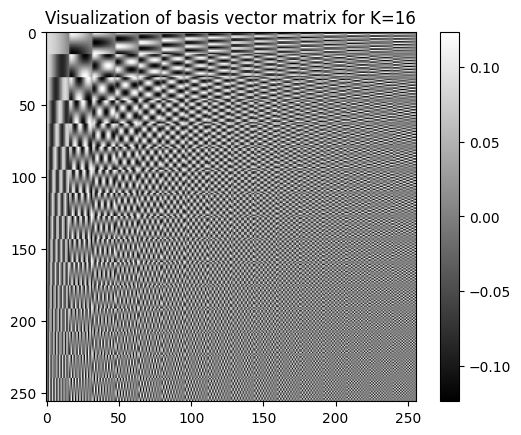

coordinates: (273, 49)


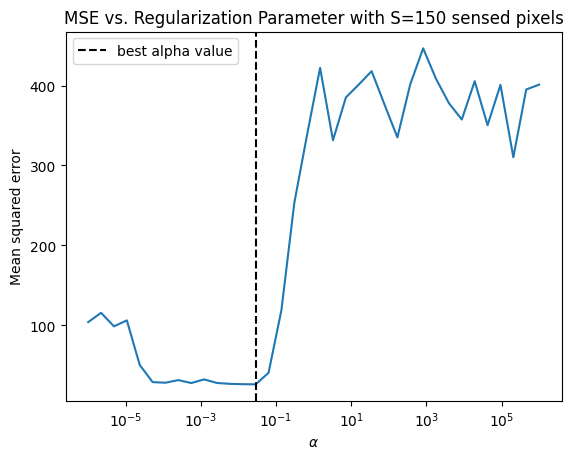

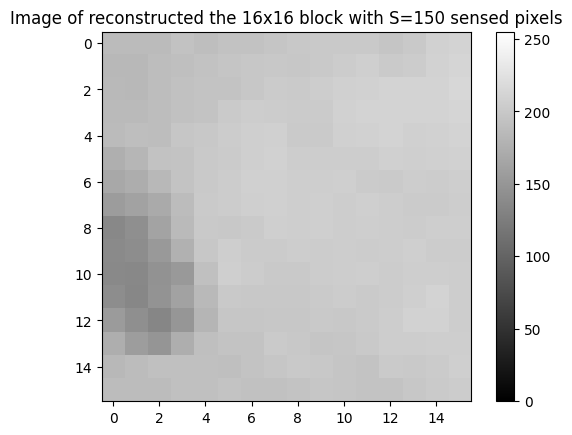

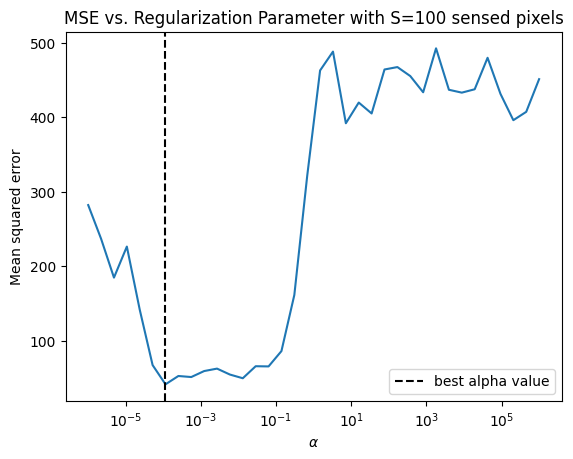

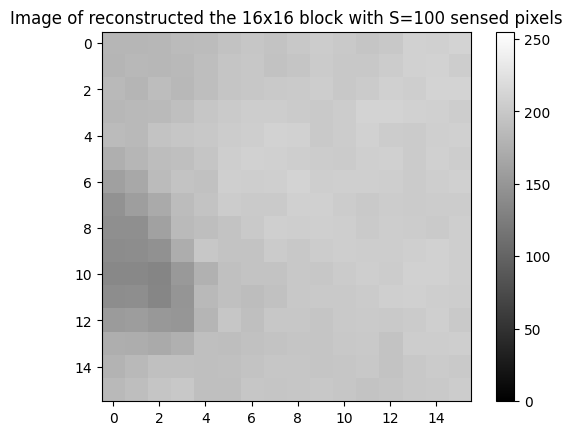

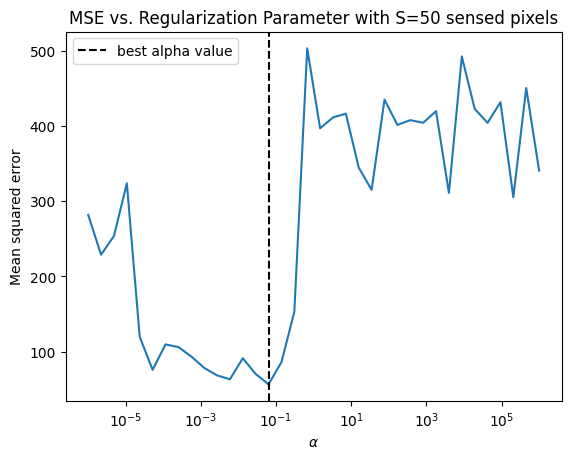

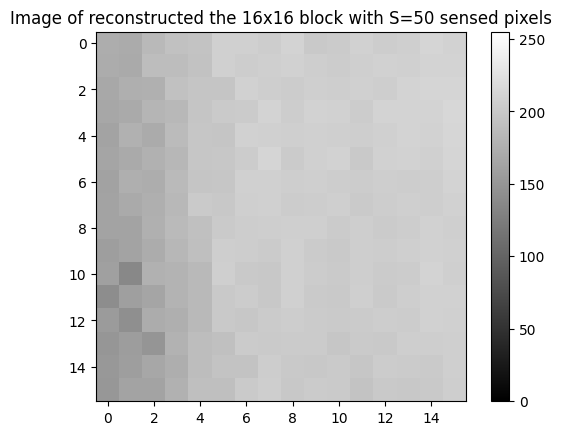

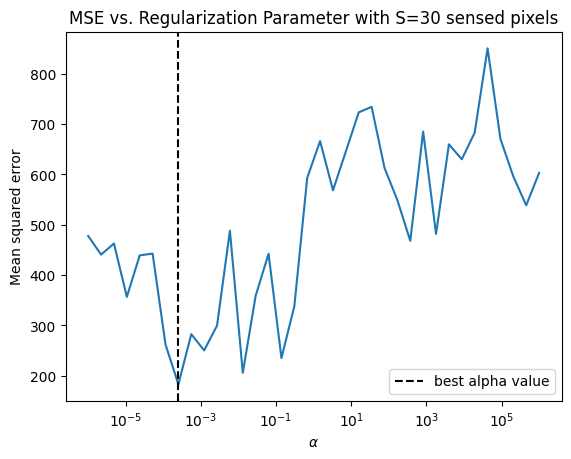

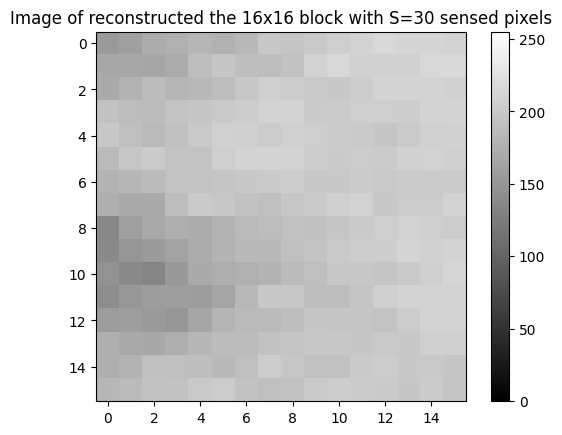

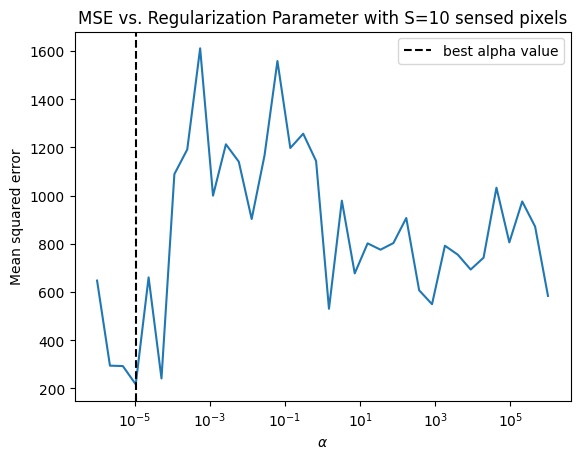

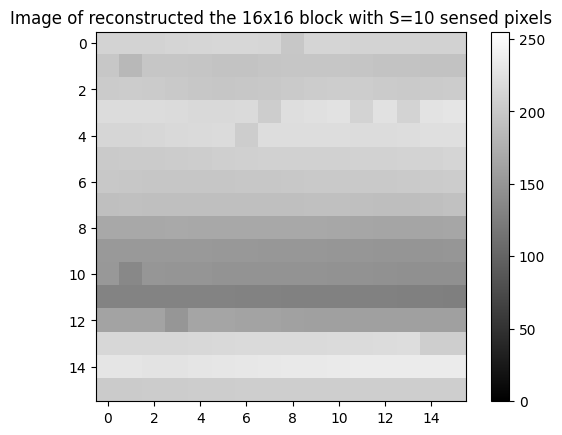

In [13]:
# nature image block
k = 16
basis_vector_matrix_16 = generate_and_visualize_basis_matrix(k)
initials = 'RD'
x, y = 16 * (ord(initials[0]) - ord('A')), 16 * (ord(initials[1]) - ord('A'))
print(f'''coordinates: ({x + 1}, {y + 1})''')
S_vals = [150, 100, 50, 30, 10]
nature_block = np.array(nature.crop((x, y, x + k, y + k))).astype('float')
for S in S_vals:
    corrupted = corrupt_block(np.copy(nature_block), S)
    reconstructed, alpha_best = reconstruct_block(corrupted, basis_vector_matrix_16, S, show_MSE_vs_alpha=True)
    plot_checkpoint_reconstructed_block(reconstructed, k, S)

In [6]:
basis_vector_matrix_4 = generate_and_visualize_basis_matrix(4)

NameError: name 'generate_and_visualize_basis_matrix' is not defined